# Predict the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 60/20/20
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 253.81
- MAE: 194.94
- MAPE: 1.68 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> ITD - 6 2 2
split = 1  # 6 2 2
stock = 2  # ITD

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1247,2024-02-26,9520,9700,9510,9700,8700,ITD
1248,2024-02-27,9690,9690,9210,9640,17500,ITD
1249,2024-02-28,9450,10000,9400,9890,35700,ITD
1250,2024-02-29,9890,9960,9430,9950,53400,ITD


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [39]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [40]:
# Shape of the dataframe
df.shape

(1252, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,9957.242013,10146.194089
std,2982.882283,3069.392776
min,5130.000000,5320.000000
25%,7430.000000,7515.000000
50%,9825.000000,10000.000000
75%,11550.000000,11700.000000
max,20700.000000,21430.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

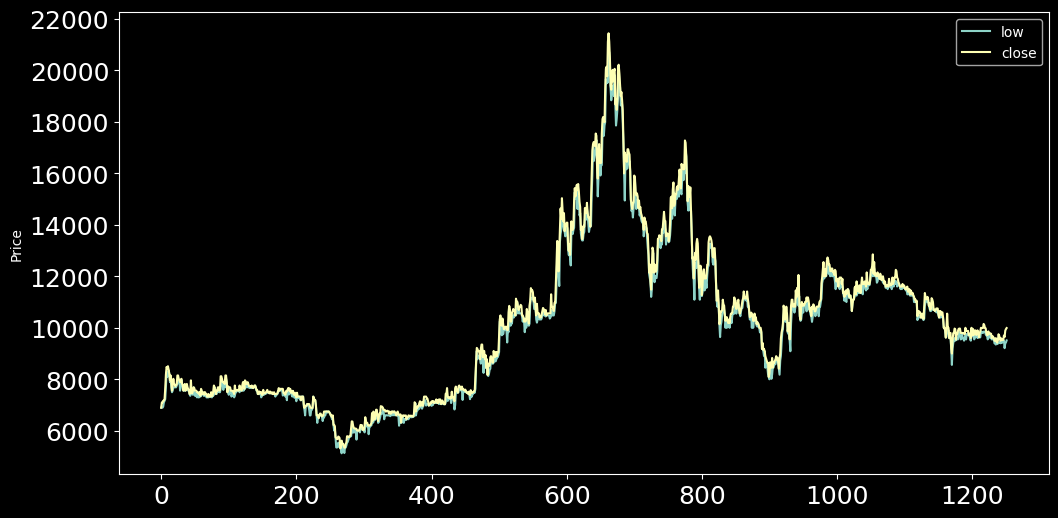

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.6093516999032065,
 0.4788943246246586,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 17400.706231746055)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.644
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.617
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


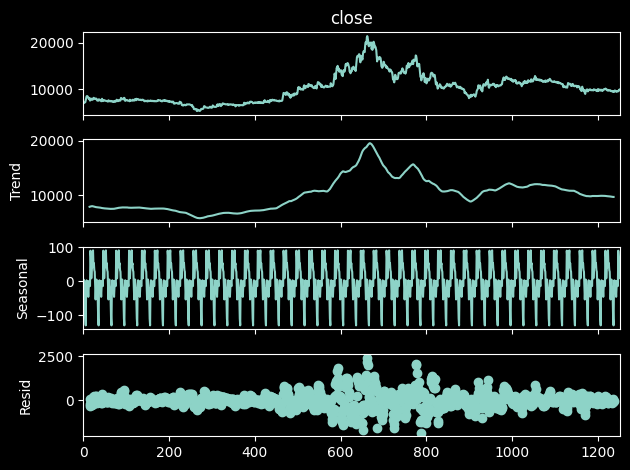

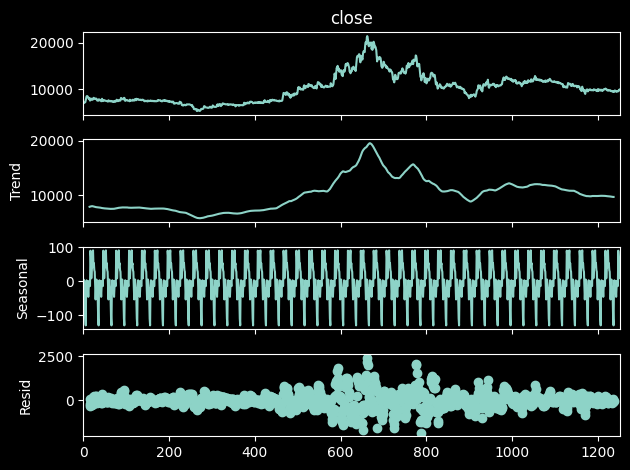

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-7.207420230961438,
 2.2809590411483338e-10,
 13,
 736,
 {'1%': -3.4392661055744767,
  '5%': -2.86547495466493,
  '10%': -2.56886540295664},
 10325.418845030737)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

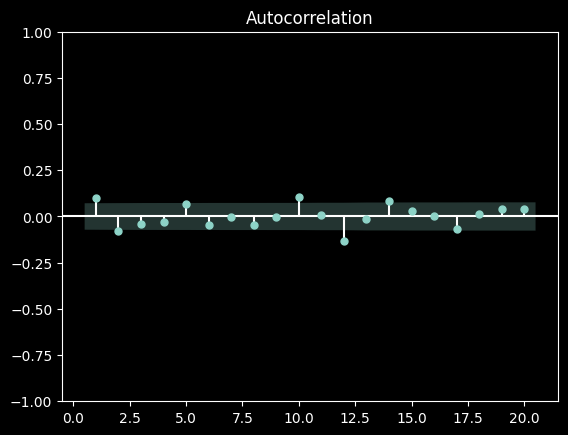

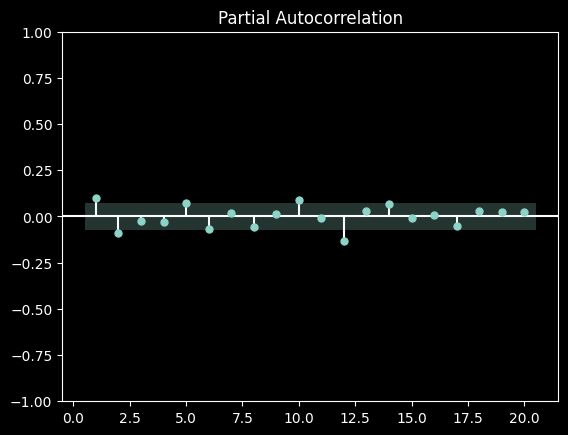

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=10636.075, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=10627.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=10626.994, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=10634.797, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=10629.061, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=10622.967, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=10626.157, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[5] intercept   : AIC=10622.779, Time=0.25 sec
 ARIMA(0,1,1)(2,0,0)[5] intercept   : AIC=10620.783, Time=0.13 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=10628.639, Time=0.27 sec
 ARIMA(1,1,1)(2,0,0)[5] intercept   : AIC=10618.892, Time=0.73 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=10624.289, Time=0.32 sec
 ARIMA(1,1,1)(2,0,1)[5] intercept   : AIC=10620.805, Time=0.50 sec
 ARIMA(1,1,1)(1,0,1)[5] i

In [56]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  751
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 5)   Log Likelihood               -5302.599
Date:                            Sun, 26 May 2024   AIC                          10617.199
Time:                                    13:32:17   BIC                          10644.919
Sample:                                         0   HQIC                         10627.880
                                            - 751                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7829      0.097      8.035      0.000       0.592       0.974
ma.L1         -0.6695      0.101   

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(1, 1, 2),
    seasonal_order=(2, 0, 0, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([13646.45500706, 13656.72236533, 13883.29035682, 14305.03821935,
       15379.86463915, 14558.93922427, 14974.71834654, 15600.45930778,
       15056.6383546 , 14681.98872881, 15293.8065916 , 15485.39980966,
       15339.56271175, 15800.48038851, 15668.34829679, 15435.85051195,
       15997.14090475, 16220.27529677, 15577.54354243, 15526.82844742,
       16222.38803538, 16457.10846563, 16089.02661978, 16416.09604815,
       16365.14495183, 17294.95429665, 17019.1362048 , 15997.58840705,
       15200.99089263, 14884.41308525, 15619.95812837, 15201.17685792,
       14884.51012533, 14884.5523751 , 13955.09860908, 12974.59739097,
       12371.97357964, 12137.04575678, 11350.58253255, 12647.78880537,
       12790.80997588, 12606.96440269, 13485.38060819, 13117.68540317,
       12698.91759935, 11820.51777177, 11350.67609861, 12280.16347933,
       12280.17090255, 11493.69218955, 11626.48235031, 11912.48179491,
       12464.04691089, 11718.42287682, 12188.27540703, 12045.28238018,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([12093.91288161, 11859.04200956, 11850.68586364, 11751.51498671,
       12060.28443672, 11923.70324819, 11869.63409565, 11851.88720227,
       11604.27494408, 11505.40582741, 11310.31034869, 11512.11765968,
       11304.99600418, 11255.20903442, 11715.49433267, 11768.99114988,
       11717.43596684, 11409.43752648, 11512.33455607, 11512.68992571,
       11309.40933578, 10900.64191141, 11206.69019898, 11360.12004752,
       11360.23941586, 11462.7072333 , 11564.81057988, 11564.67207519,
       11513.7033447 , 11615.90334747, 11616.0336996 , 11616.03023929,
       11616.00038756, 11616.04263732, 11616.07132798, 11769.33442516,
       11973.62395535, 11565.05655267, 11973.64220131, 11973.65867195,
       11973.68254143, 11769.40878238, 11718.34253121, 11871.56606564,
       11769.43514267, 11973.72916573, 11973.73576737, 11922.67022676,
       12075.88904394, 12331.24780985, 12535.53662113, 12484.47099902,
       12280.19323814, 12382.33891731, 12586.62503132, 12280.20651759,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[20305.37814049 20287.09859373 20291.05191449 20306.33143355
 20320.98756233 20349.92723444 20359.23801323 20353.80058653
 20373.85011828 20389.4313976  20410.92724417 20420.76216323
 20430.23183303 20443.8247946  20456.78537766 20471.5211969
 20483.34594519 20494.07975943 20507.14532639 20519.81016271
 20533.12089807 20545.2266576  20557.16162394 20569.68954521
 20582.11838022 20594.75473504 20607.026619   20619.19758099
 20631.60878183 20643.97732198]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

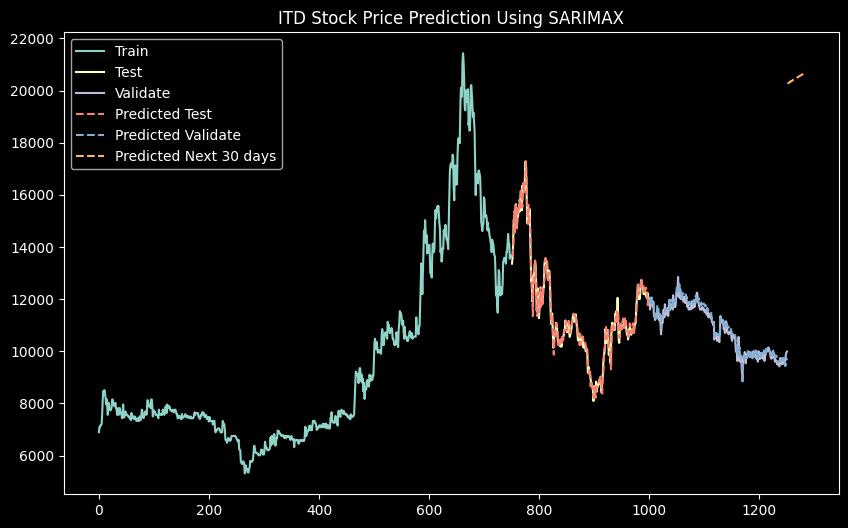

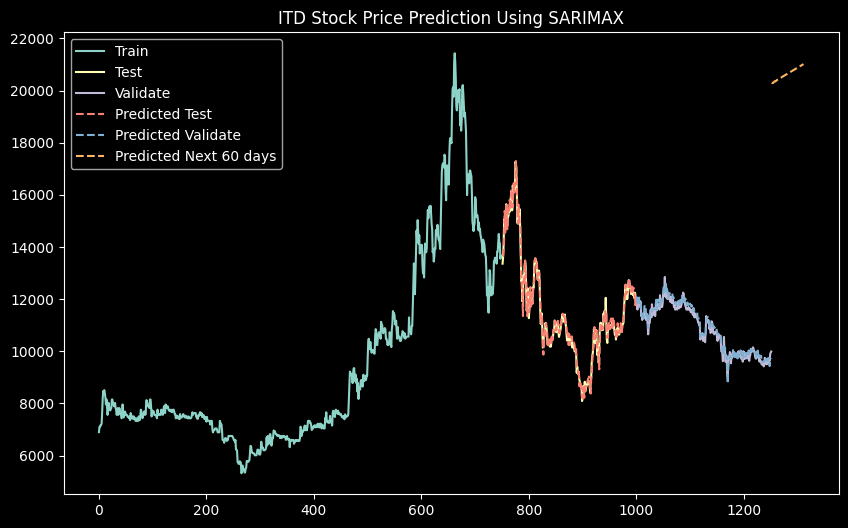

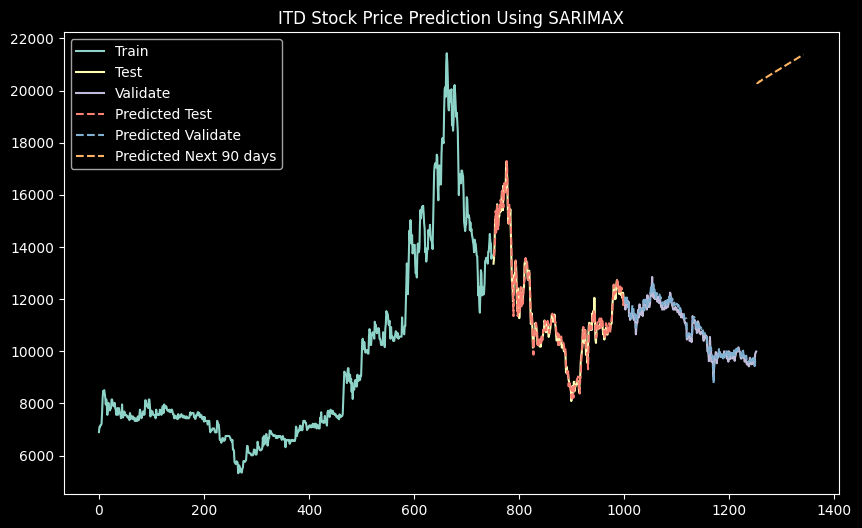

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 253.80814159268863
MAE on test data: 194.94263039249955
MAPE on test data: 1.6780582684023615 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 179.18033311113302
MAE on validation data: 154.45378100803165
MAPE on validation data: 1.4225190253494184 %
